# Purpose

The purpose of this notebook is to house code and figures for aggregate properties the street/metro multiplex. These are properties that we can learn only from the multiplex and flows assigned on it, in contrast to properties (like path length distributions) that can be learned only via route-wise analysis. 

In [1]:
import matplotlib
matplotlib.use('Agg')
% matplotlib inline 
from matplotlib import cm
import Image

from metro import multiplex as mx
from metro import assignment
from metro import utility
from metro import ita
from metro import viz

import pandas as pd
import numpy as np
import cProfile
import time
import networkx as nx
import matplotlib.pyplot as plt # convenience for plotting
from matplotlib import pylab
import matplotlib.gridspec as gridspec
import Image

pylab.rcParams['savefig.dpi'] = 300 # should be ~300 for final figs
import seaborn as sns
sns.set_style("white")

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Read the multiplex

In [2]:
multi = mx.read_multi(nodes_file_name = '3_throughput/mx_flow_nodes.txt', 
                      edges_file_name = '3_throughput/mx_flow_edges.txt')

In [3]:
multi.read_od(layer = 'taz', # keys are in this layer
          key = 'taz', # this is the key attribute
          od_file = '1_data/taz_od/0_1.txt', # here's where the file lives
          sep = ' ') # this is what separates entries

In [4]:
multi.summary()

OD: loaded

layer           	nodes 	edges
----------------------------------------
metro--streets   	0 	234
taz              	4243 	0
streets          	10728 	21508
taz--streets     	0 	8486
metro            	117 	250


In [5]:
G = multi.layers_as_subgraph(['streets'])

In [6]:
def edge_wise_cor(multi, attr1, attr2, weight):
    df = multi.edges_2_df(['streets'], [attr1, attr2, weight])
    for attr in [attr1, attr2]:
        df[attr + '_weighted'] = df[attr] * df[weight] 
    df = df.dropna(thresh = 5)
    return np.corrcoef(df[attr1 + '_weighted'], df[attr2 + '_weighted'])[0][1]

In [7]:
def od_total(od):
    return np.sum(np.sum(od[o].values()) for o in od)


In [8]:
def metro_flow(beta): 
    flow = 'flow_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow, 'dist_km'])
    df['weighted_flow'] = df[flow] * df['dist_km']
    sums = df.groupby('layer').sum()['weighted_flow']
    metro, streets = (sums['metro'], sums['streets'])
    return 1.0 * metro / (metro + streets)

## Flowmaps as functions of $\beta$. 

In [9]:
def time_lost(beta):
    flow = 'flow_' + str(beta)
    cong_time = 'congested_time_m_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow, 'capacity', 'free_flow_time_m', cong_time])
    df['time_lost'] = df[flow]* (df[cong_time] - df['free_flow_time_m'])
    df = df[df.layer == 'streets']
    return df.sum()['time_lost'] / od_total(multi.od) * 4

def time_free(beta):
    flow = 'flow_' + str(beta)
    cong_time = 'congested_time_m_' + str(beta)
    
    df = utility.edges_2_df(multi.G, ['layer', flow, 'capacity', 'free_flow_time_m', cong_time])
    df['time_free'] = df[flow] * df['free_flow_time_m']

    streets_part = df[df.layer == 'streets'].sum()['time_free']
    
    df['time_free'] = df[flow] * df[cong_time]
    metro_part = df[df.layer == 'metro'].sum()['time_free']
    return (streets_part + metro_part) / od_total(multi.od) * 4

def time_spent(beta):
    flow = 'flow_' + str(beta)
    cong_time = 'congested_time_m_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow,  cong_time])
    df['time_spent'] = df[flow]*df[cong_time]
    return df.sum()['time_spent'] / od_total(multi.od) * 4

def time_on_road(beta): 
    flow = 'flow_' + str(beta)
    cong_time = 'congested_time_m_' + str(beta)
    df = utility.edges_2_df(multi.G, ['layer', flow,  cong_time])
    df['time_spent'] = df[flow]*df[cong_time]
    return df[df['layer'] == 'streets'].sum()['time_spent'] / od_total(multi.od) * 4

In [10]:
time_on_road(0.8)

13.541751012948167

In [11]:
cmap = 'viridis'
vmax = 1.5

center_point = (46.7167, 24.6333)
l = .2

xlim = (center_point[0] - l, center_point[0] + l)
ylim = (center_point[1] - l + .05, center_point[1] + l + .05)



In [12]:
def speed_ratio(beta):
    flow = 'flow_' + str(beta)
    time = 'congested_time_m_' + str(beta)
    
    try: 
        street_time = multi.mean_edge_attr_per(layers = ['streets'], attr = time, weight_attr = flow)
        metro_time = multi.mean_edge_attr_per(layers = ['metro'], attr = time, weight_attr = flow)

        street_dist = multi.mean_edge_attr_per(layers = ['streets'], attr = 'dist_km', weight_attr = flow)
        metro_dist = multi.mean_edge_attr_per(layers = ['metro'], attr = 'dist_km', weight_attr = flow)

        street_speed = street_dist / street_time
        metro_speed = metro_dist / metro_time
        ratio = metro_speed / street_speed 
        return ratio
    except ZeroDivisionError:
        return float('NaN')

In [13]:
speed_ratio(1.0)

1.433863738905357

In [14]:
reload(viz)
def make_flowmap(beta, ax):
    J_m = metro_flow(beta)
    
    if beta == 100:
        title_str = r'No metro, $J_m = 0$' 
    else:
        title_str = r'$\beta=$' + str(beta) + r',  $\alpha = $' + str(round(speed_ratio(beta),1)) + r',  $J_m = $' + str(int(100 * J_m)) + '%'
    
    ax.set_title(title_str, fontsize = 7)
    
    ax.set(xlim = xlim, ylim = ylim)
    viz.flow_plot(multi, 'flow_' + str(beta), 
                  ax, 
                  cmap = cmap, 
                  background = False, 
                  edge_vmin = 0, 
                  edge_vmax = vmax,
                  scale = .0001)

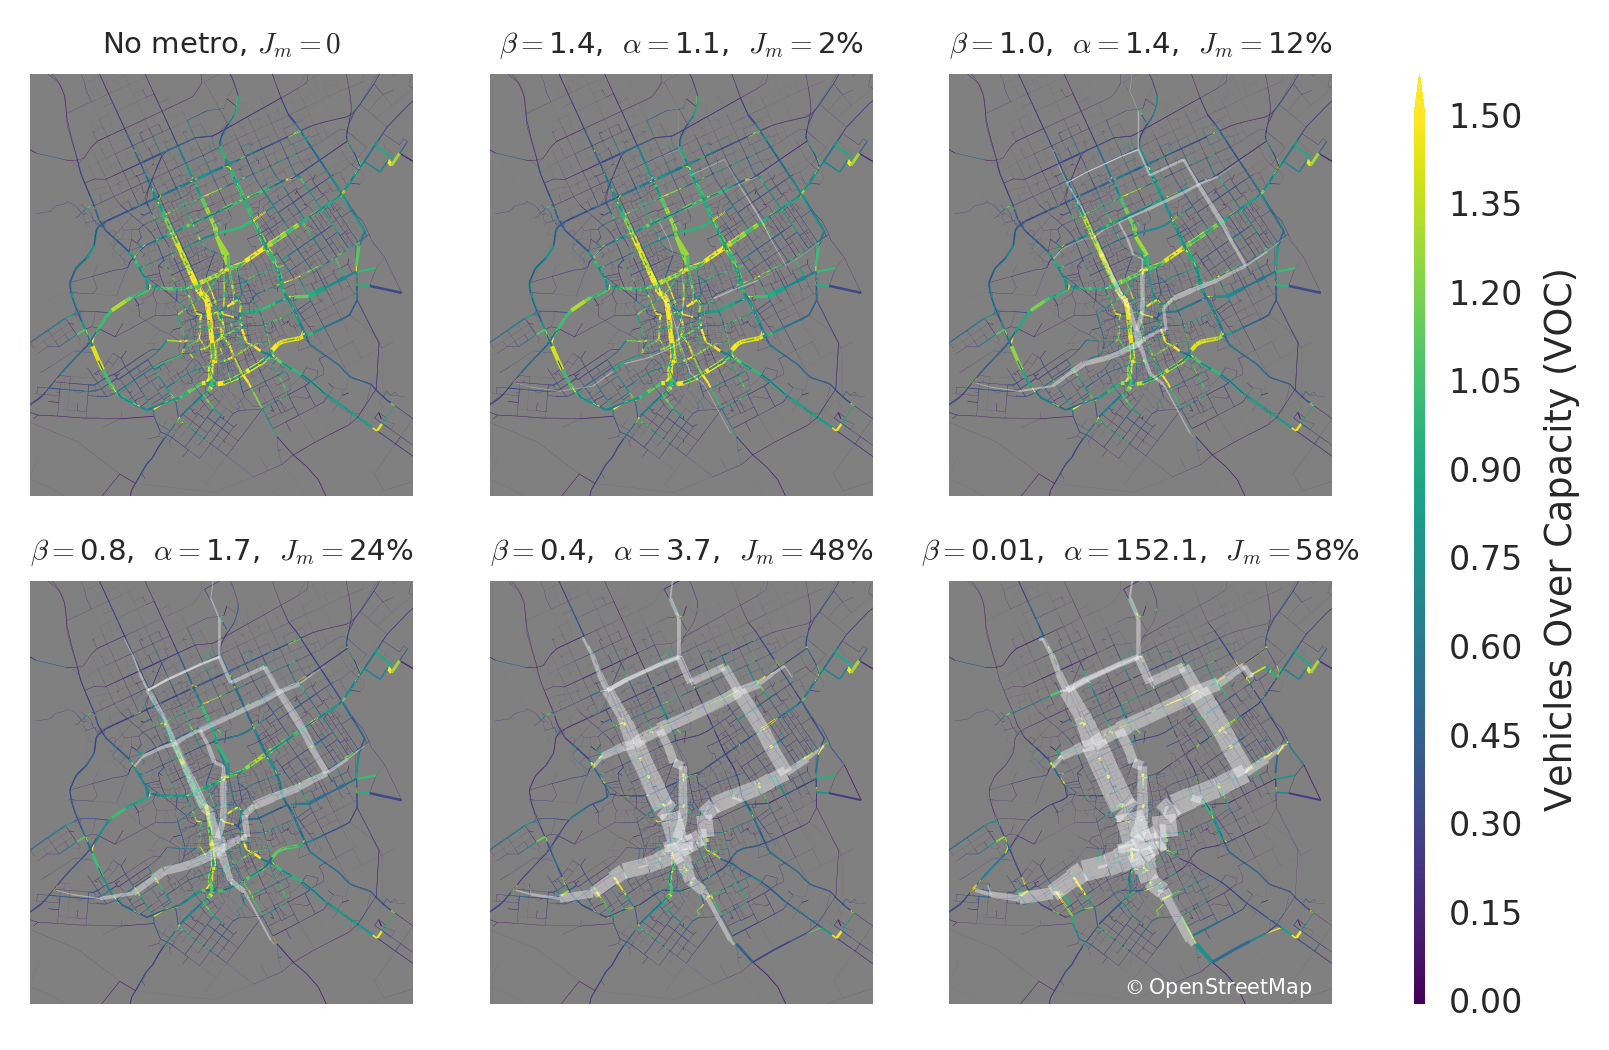

In [15]:
sns.set_context("paper")

reload(viz)
betas = [100.0, 1.4, 1.0, .8, .4, .01]
# betas = [0.2]

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(7,4))
f.subplots_adjust(hspace=.2, wspace=.2)

for beta, ax in zip(betas, [ax1, ax2, ax3, ax4, ax5, ax6]):
    make_flowmap(beta, ax)
    ax.patch.set_facecolor('grey')
    for line in ['right', 'top', 'bottom', 'left']:
        ax.spines[line].set_visible(False)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

cols = plt.get_cmap(cmap)
m = cm.ScalarMappable(cmap=cols)
m.set_array([0, vmax])

cax,kw = matplotlib.colorbar.make_axes([ax1, ax2, ax3, ax4, ax5, ax6])
cbar = plt.colorbar(m, cax=cax, extend = 'max', **kw)
cbar.set_label('Vehicles Over Capacity (VOC)')

cax.tick_params(axis='y')
cax.set_aspect(75)

# plt.subplots_adjust(left=.01, right=0.99, top=0.99, bottom=0.01)

cbar.outline.set_linewidth(0)

ax6.text(0.95, 0.01, r'$\copyright$ OpenStreetMap',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax6.transAxes,
        color='white', fontsize=5)


plt.savefig('4_figs/flow_maps.tif', bbox_inches = 'tight')



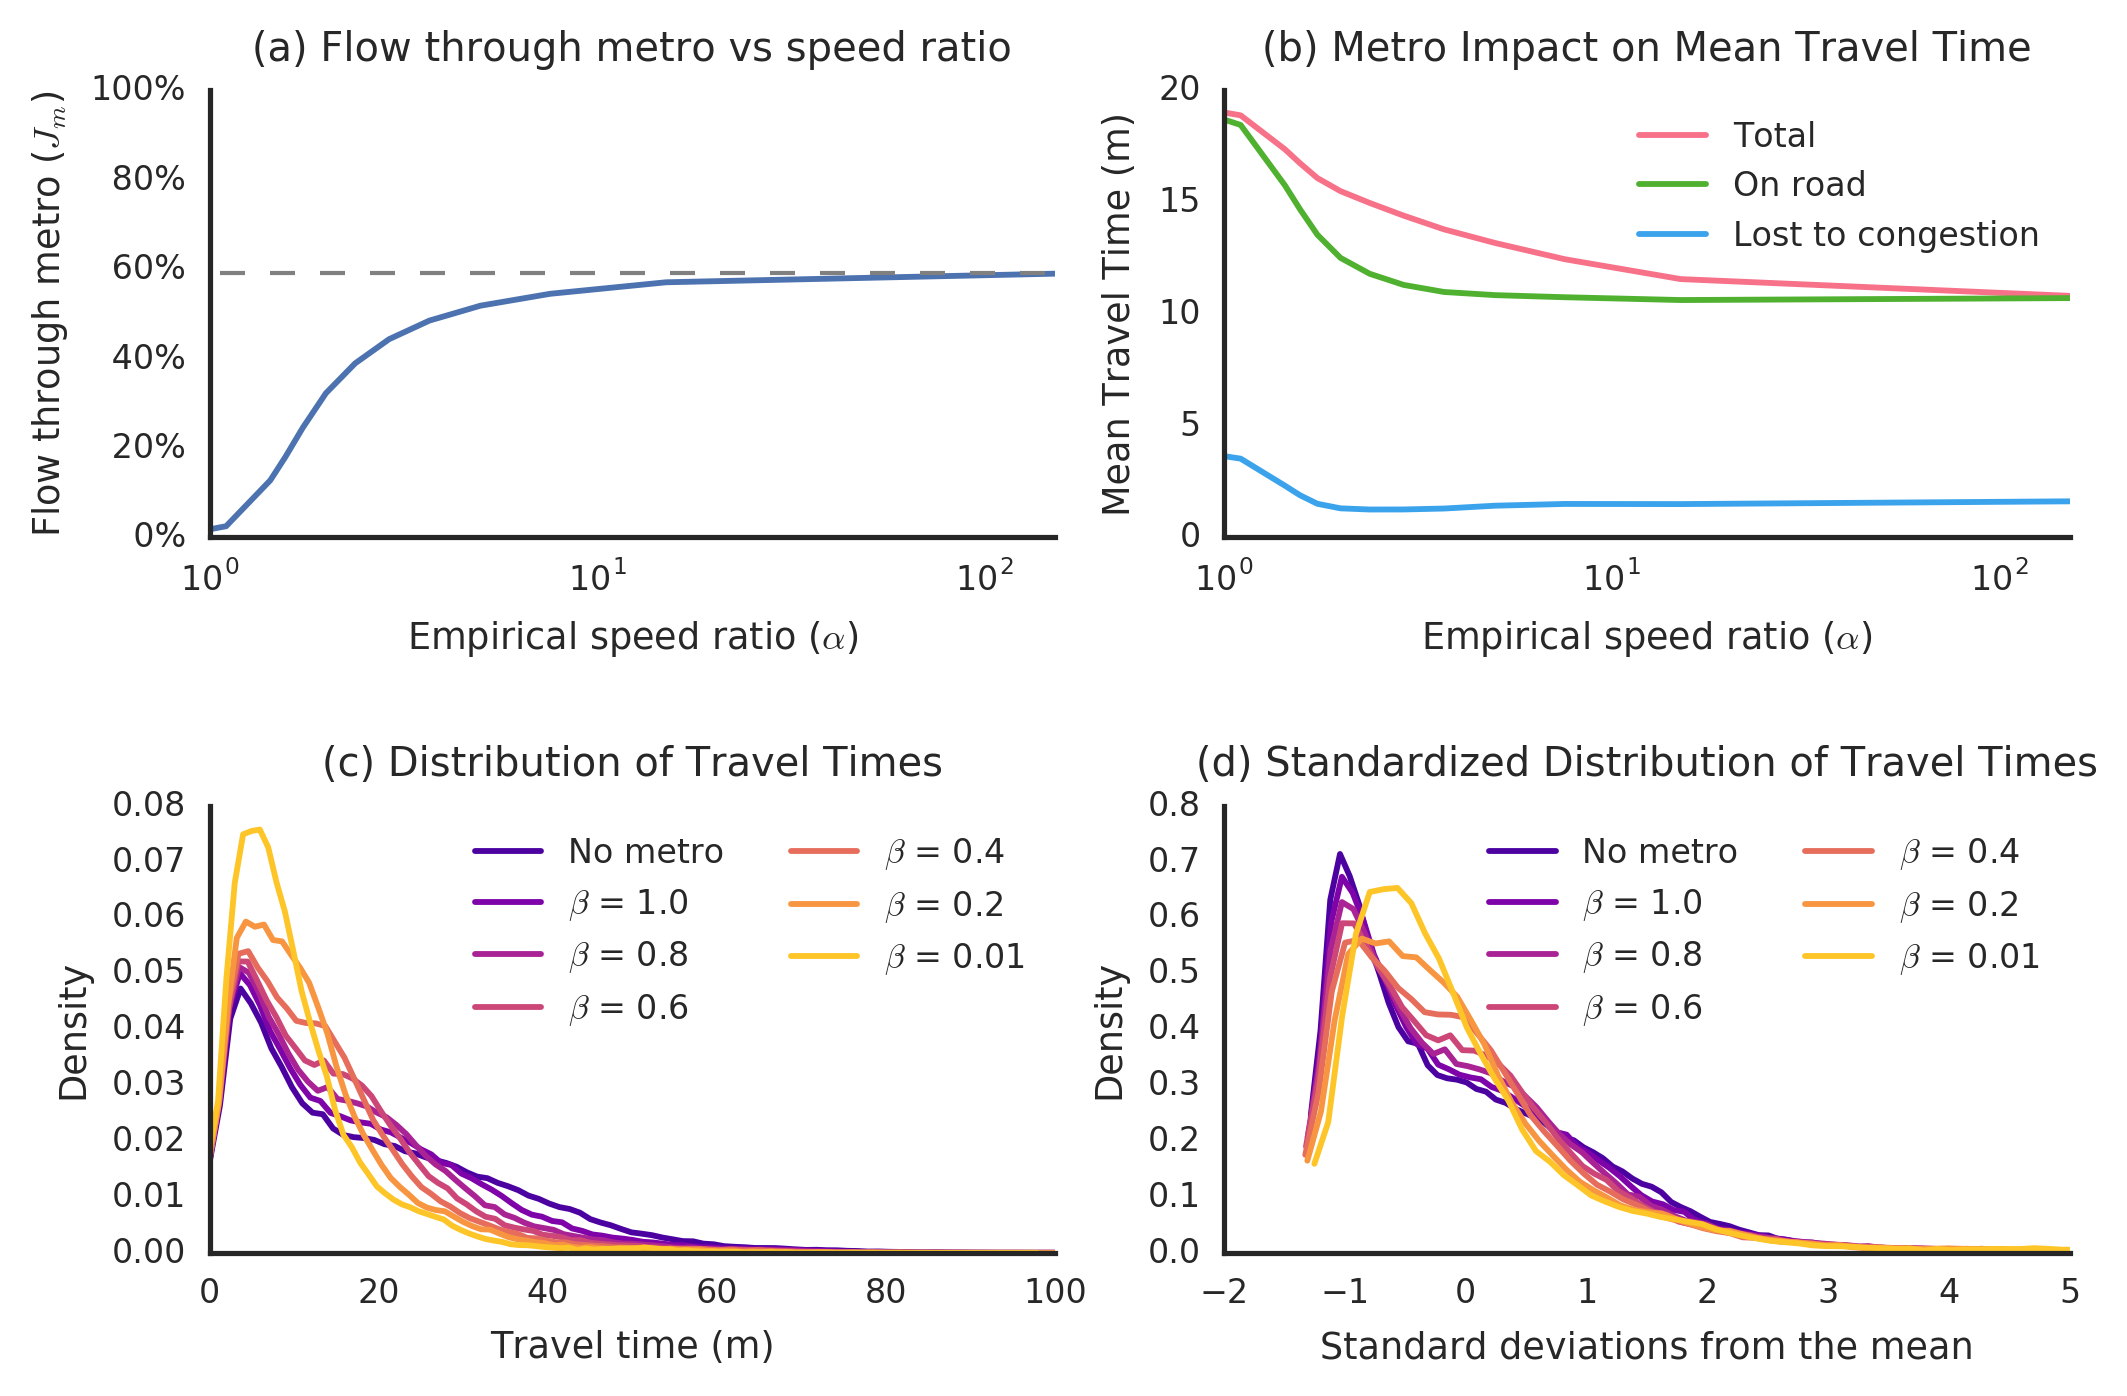

In [16]:
sns.set_context("paper")
import operator

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,5))
f.subplots_adjust(hspace=.6)

# -----------------
sns.set_style("ticks")

cols = sns.color_palette("husl", 3)

betas = pd.read_csv('betas.csv').beta
betas = betas[betas >= 0.01]

x = [speed_ratio(beta) for beta in betas]

labs = ['Total', 'On road', 'Lost to congestion',]
funs = [time_spent, time_on_road, time_lost]

for i in range(3):
    y = [funs[i](beta) for beta in betas]
    ax2.semilogx(x,y, label = labs[i], color = cols[i])

ax2.set(xlim = (1, np.nanmax(x)),
        ylim = (0, None), 
        xlabel = r'Empirical speed ratio ($\alpha$)', 
        ylabel = 'Mean Travel Time (m)')
ax2.set_title('(b) Metro Impact on Mean Travel Time', y=1.02)

ax2.legend(loc = 1)
sns.despine()

# # ---------------------------------------
sns.set_style("ticks")
x = [speed_ratio(beta) for beta in betas]
y = [metro_flow(beta) for beta in betas]

ax1.plot(x,y)
# ax1.plot(x,y, '--',lw = 1)
ax1.plot([np.nanmin(x), np.nanmax(x)], [metro_flow(0.001), metro_flow(0.001)], '--', color = '0.50',  lw = 1)

ax1.set_xscale('log')
ax1.set(xlabel = r'Empirical speed ratio ($\alpha$)', 
        ylabel = r'Flow through metro ($J_m$)',
        ylim = (0,1),
        xlim = (1, np.nanmax(x)))

ax1.set_title('(a) Flow through metro vs speed ratio',  y=1.02)
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.0f}%'.format(val*100) for val in vals])

# ax1.tick_params(axis='x', which='minor')
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

sns.despine()
# # ---------------------------------------

betas = [1000.0, 1.0, 0.8, 0.6, 0.4, 0.2, 0.01]
cols = sns.color_palette('plasma', len(betas))
# sns.set_palette(sns.color_palette("plasma", len(betas)))

i = 0
for beta in betas:
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    if beta == 1000.0:
        lab = 'No metro'
    else:
        lab = r'$\beta$ = ' + str(beta)
    viz.weighted_hist(ax = ax3, 
                      measure = df.congested_time_m, 
                      weights = df.flow, 
                      label = lab,
                      standardized = False,
                      color = cols[i])
    
    viz.weighted_hist(ax = ax4, 
                      measure = df.congested_time_m, 
                      weights = df.flow, 
                      label = lab, 
                      standardized = True, 
                      color = cols[i])
    i += 1
    
ax3.legend(ncol = 2)
sns.despine()
ax4.legend(ncol = 2)
sns.despine()

ax3.set(xlim = (0,100), 
        xlabel = 'Travel time (m)', 
        ylabel = 'Density')

ax3.set_title('(c) Distribution of Travel Times', y=1.02)


ax4.set(xlim = (-2, 5), 
        xlabel = 'Standard deviations from the mean', 
        ylabel = 'Density')

ax4.set_title('(d) Standardized Distribution of Travel Times',  y=1.02)

f.savefig('4_figs/flow_stats.tif', facecolor = f.get_facecolor(), bbox_inches = 'tight')


plt.show()

In [17]:
betas = pd.read_csv('betas.csv').beta
betas

0     1000.000
1      100.000
2       10.000
3        5.000
4        4.000
5        3.000
6        2.000
7        1.400
8        1.000
9        0.900
10       0.800
11       0.700
12       0.600
13       0.500
14       0.400
15       0.300
16       0.200
17       0.100
18       0.010
19       0.001
Name: beta, dtype: float64

In [18]:
betas = pd.read_csv('betas.csv').beta
y = [time_on_road(beta) for beta in betas]

In [19]:
y

[19.362243796584398,
 19.362243796584398,
 19.362243796584398,
 19.361808995819402,
 19.359691888043578,
 19.354373812086148,
 19.25635946568832,
 18.450239919517724,
 15.754868426355491,
 14.683316394951451,
 13.541751012948167,
 12.50504055944759,
 11.794075700453202,
 11.296172660615238,
 10.980280213932527,
 10.839017692616109,
 10.74501807081923,
 10.619445932737072,
 10.706023465002417,
 10.741883338401152]

In [20]:
zip(betas, y)

[(1000.0, 19.362243796584398),
 (100.0, 19.362243796584398),
 (10.0, 19.362243796584398),
 (5.0, 19.361808995819402),
 (4.0, 19.359691888043578),
 (3.0, 19.354373812086148),
 (2.0, 19.25635946568832),
 (1.3999999999999999, 18.450239919517724),
 (1.0, 15.754868426355491),
 (0.90000000000000002, 14.683316394951451),
 (0.80000000000000004, 13.541751012948167),
 (0.69999999999999996, 12.50504055944759),
 (0.59999999999999998, 11.794075700453202),
 (0.5, 11.296172660615238),
 (0.40000000000000002, 10.980280213932527),
 (0.29999999999999999, 10.839017692616109),
 (0.20000000000000001, 10.74501807081923),
 (0.10000000000000001, 10.619445932737072),
 (0.01, 10.706023465002417),
 (0.001, 10.741883338401152)]

In [21]:
zip(betas, 1.0 * (max(y) - y) / (max(max(y) - y)))

[(1000.0, 0.0),
 (100.0, 0.0),
 (10.0, 0.0),
 (5.0, 4.9732450843210506e-05),
 (4.0, 0.00029188694289414768),
 (3.0, 0.00090016772900503223),
 (2.0, 0.012111034996465432),
 (1.3999999999999999, 0.10431487622948891),
 (1.0, 0.41261109159870901),
 (0.90000000000000002, 0.53517506346348886),
 (0.80000000000000004, 0.66574715260257489),
 (0.69999999999999996, 0.78432594964734215),
 (0.59999999999999998, 0.86564601103573646),
 (0.5, 0.9225960912722776),
 (0.40000000000000002, 0.95872782525516753),
 (0.29999999999999999, 0.97488541273646556),
 (0.20000000000000001, 0.98563707636414477),
 (0.10000000000000001, 1.0),
 (0.01, 0.99009727393751668),
 (0.001, 0.98599562662081264)]

In [23]:
z = [metro_flow(beta) for beta in betas]
zip(betas, z)

[(1000.0, nan),
 (100.0, nan),
 (10.0, nan),
 (5.0, 7.725431780547724e-06),
 (4.0, 3.4240597261912884e-05),
 (3.0, 0.00013072460297727971),
 (2.0, 0.0020023909627161231),
 (1.3999999999999999, 0.0251136073474864),
 (1.0, 0.12779905942160957),
 (0.90000000000000002, 0.18025302502921409),
 (0.80000000000000004, 0.245554154694309),
 (0.69999999999999996, 0.32275598245593251),
 (0.59999999999999998, 0.38944771222397767),
 (0.5, 0.44347345645465602),
 (0.40000000000000002, 0.48502177294884369),
 (0.29999999999999999, 0.51834569245090156),
 (0.20000000000000001, 0.54496293564778131),
 (0.10000000000000001, 0.57070330511529244),
 (0.01, 0.58996019546425471),
 (0.001, 0.59229315802409765)]

In [25]:
1.0 * 39/59

0.6610169491525424